In [1]:
%matplotlib inline

/opt/gypsy/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Check carol's log for warnings

In [1]:
%%bash 
grep -i -B 2 -A 1 warning ../private-data/carol-gypsy-sim-1000.log

DEBUG 2016-10-28 15:27:45,701 getting basal area from time zero to time of data for aspen
DEBUG 2016-10-28 15:27:45,703 getting basal area from time zero to time of data for aspen
WARNING 2016-10-28 15:27:45,704 GYPSYNonSpatial.BAfactorFinder_Aw() Slow convergence with Basal Area: nan and factor:-0.8302850251 
DEBUG 2016-10-28 15:27:45,707 Getting basal area factor for white spruce
--
DEBUG 2016-10-28 15:28:16,032 getting basal area from time zero to time of data for aspen
DEBUG 2016-10-28 15:28:16,032 getting basal area from time zero to time of data for aspen
WARNING 2016-10-28 15:28:16,035 GYPSYNonSpatial.BAfactorFinder_Aw() Slow convergence with Basal Area: nan and factor:-1.2568943712 
DEBUG 2016-10-28 15:28:16,035 Getting basal area factor for white spruce
--
DEBUG 2016-10-28 15:33:03,299 getting basal area from time zero to time of data for aspen
DEBUG 2016-10-28 15:33:03,301 getting basal area from time zero to time of data for aspen
WARNING 2016-10-28 15:33:03,302 GYPSYNonSpat

## Run & profile prep

In [7]:
%%bash
python -m cProfile -s cumtime  "$(which gypsy)" prep ../private-data/1000-plots.csv > profile_prep_1000.txt

INFO     Running prep...
INFO     0% complete
INFO     10% complete
INFO     20% complete
INFO     30% complete
INFO     40% complete
INFO     50% complete
INFO     60% complete
INFO     70% complete
INFO     80% complete
INFO     90% complete


In [9]:
%%bash
cat profile_prep_1000.txt


 GYPSYNonSpatial.densityNonSpatialAw()
 Slow convergence

 asaCompileAgeGivenSpSiHt.computeTreeAge()
 Tree Age Search Routine Terminated; treeAge > 1000
 rowIndex: 0 siSp: Pl treeHt: 26.0 treeSi: 10.7021513718 current treeAge: 1013.50035006

 asaCompileAgeGivenSpSiHt.computeTreeAge()
 Tree Age Search Routine Terminated; treeAge > 1000
 rowIndex: 0 siSp: Pl treeHt: 25.39 treeSi: 10.7537466946 current treeAge: 1001.95421726
         23532691 function calls (22888860 primitive calls) in 163.187 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.021    0.021  163.198  163.198 gypsy:3(<module>)
        1    0.000    0.000  154.965  154.965 core.py:714(__call__)
        1    0.000    0.000  154.965  154.965 core.py:637(main)
        1    0.000    0.000  154.963  154.963 core.py:1021(invoke)
        2    0.000    0.000  154.958   77.479 core.py:884(invoke)
        2    0.000    0.000  154.958   77.479 core.py:497(in

## Run simulate

Advised to run this in terminal to get realtime progerss update

``` bash
# python -m cProfile -s cumtime  "$(which gypsy)" simulate ../private-data/1000-plots.csv_prepped.csv > profile_sim_1000.txt 
# don't profile, it's too slow on 1K plots. only need to profile on a couple with/without slow convergence
gypsy simulate ../private-data/1000-plots.csv_prepped.csv > profile_sim_1000.txt
```

Now with logs that indicate the time taken for each plot.

We should compile statistics related to time.

## Things to fix from simulation

```
/opt/gypsy/gypsy/GYPSYNonSpatial.py:1088: RuntimeWarning: divide by zero encountered in log10
  f_AwN = f_Aw * (1+(numpy.log10(BA_AwT) + numpy.log10(abs(BA_AwB)))/ (100* numpy.log10(abs(BA_AwB))))
/opt/gypsy/gypsy/GYPSYNonSpatial.py:1088: RuntimeWarning: invalid value encountered in double_scalars
  f_AwN = f_Aw * (1+(numpy.log10(BA_AwT) + numpy.log10(abs(BA_AwB)))/ (100* numpy.log10(abs(BA_AwB))))
/opt/gypsy/gypsy/GYPSYNonSpatial.py:515: RuntimeWarning: invalid value encountered in double_scalars
  X4 = SC_Aw**a5
  
/opt/gypsy/gypsy/GYPSYNonSpatial.py:727: RuntimeWarning: invalid value encountered in double_scalars
  k1 = (10**-4)*a1*((a2+bhage_Sw)**2)*((1+bhage_Sw)**((a1**0.5)+a2-a3))*numpy.exp(-a2*bhage_Sw)*(SC_Sw**a6)
  
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/local/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/local/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/local/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file GYPSYNonSpatial.py, line 1555
```

## Investigate time taken as relates to data

### Use a regex to get plot id and time and join that to the result of running data prep

In [3]:
import re
import pandas as pd
from pandas.tools.plotting import scatter_matrix

plots_prepped = pd.read_csv('../private-data/1000-plots.csv_prepped.csv', index_col=0)
plots_prepped['PlotID'] = plots_prepped['PlotID'].astype(int)

pattern = '^.*plot (.*) took (.*) seconds$'
rec = re.compile(pattern)

In [18]:
matches = [rec.match(line) for line in open('gypsy.log', 'r') if rec.match(line) is not None]
times = [m.group(1,2) for m in matches]
times_df = pd.DataFrame(times, columns=['PlotID', 'duration'])
times_df['PlotID'] = times_df['PlotID'].astype(int)
times_df['duration'] = times_df['duration'].astype(float)

In [19]:
plots_times = pd.merge(plots_prepped, times_df, how='left', on='PlotID')

In [24]:
plots_times = plots_times.loc[:, plots_times.std()>1] # remove degenerate

- Boxplots of time by species or Kernel/Frequency distrs of time by species
- Scatter of time vs age

May run into trouble here cause each plot can have all the species | is not normalized. That's a significant issue. Might have to rerun the simulation and record the time taken for factorfinder

In [25]:
plots_times.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BA_Aw,1000.0,2.261215,6.095726,0.000000,0.000000,0.000000,2.150250,60.200000
BA_Pl,1000.0,11.683338,9.554224,0.000000,4.635000,9.526000,15.403500,42.232000
BA_Sw,1000.0,12.148437,10.287359,0.000000,3.139500,8.761000,20.265000,59.110000
N0_Aw,1000.0,1873.715160,13875.189870,0.000000,0.000000,0.000000,95.327499,282157.187480
N0_Pl,1000.0,2194.611432,6453.545402,0.000000,182.179221,457.613814,1684.885549,106095.785617
N0_Sw,1000.0,543.207090,478.916158,0.000000,151.431154,445.592756,798.841043,4105.288658
N_Aw,1000.0,92.664898,217.956394,0.000000,0.000000,0.000000,89.628500,1683.610000
N_Pl,1000.0,512.175388,463.543226,0.000000,169.019000,368.732000,617.231500,2096.814000
N_Sw,1000.0,478.855944,373.364738,0.000000,149.860250,427.095500,724.130750,2105.300000
PlotID,1000.0,2846.500000,288.819436,2347.000000,2596.750000,2846.500000,3096.250000,3346.000000


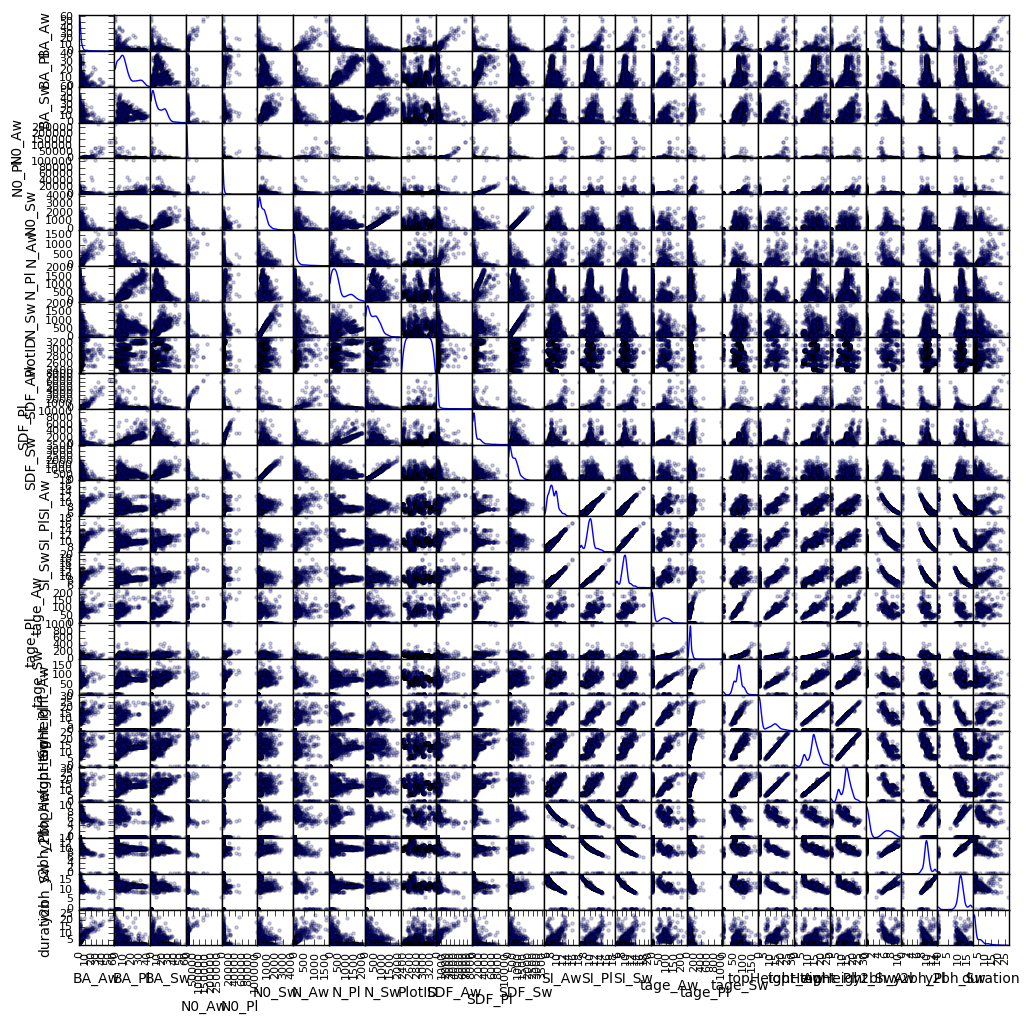

In [27]:
sm = scatter_matrix(plots_times, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [37]:
bp = plots_times.boxplot(column='duration', by='SP1')
# bp = plots_times.boxplot(column='duration', by='has_awsw')

KeyError: 'SP1'

It is useful to note that it does not appear that we need to optimize for edge cases - i.e. slow convergence

In terms of total time, slow converging plots are _% of total time

Slow plots are about 7x slower than regular plots
Regular plots occur _x more often than slow plots

Note also that plot 3185 takes 20 seconds but does not have the slow convergence issue - (or at least it is not logged)

Normal plots are _% at around 2s each on my machine (with profiling), that is ~36m for 1000 plots.
- If we run on 4 cores, can get it to 9 minutes.
- If we get time for normal plot to .5 second, we get to 9 minutes on 1 core or 2 minutes on 4 cores

- With a target of 1M plots, thats 9000 or 2000 minutes and we have to look for other optimizations. We can run on larger resources
- Can run on AWS with 32 cores and get to 1125 or ~250 minutes
- A rollup to 100K plots might be acceptable
